# Q3)

### Design a genetic algorithm to solve the polynomial fitting problem that we did in Homework #1. You need to implement a genetic algorithm using BOTH mutation AND crossover operations. You need to decide a mutation rate and a crossover rate.  
 
### Plot the following in one figure: 1) the original noisy data, 2) the polynomial you obtained in  Homework  #1,  and  3)  the  polynomial  obtained  from  this  implementation.  Compare  and  discussion the difference in performance of the two polynomials obtained with two different  methods. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

C:\Users\wyatt\AppData\Local\Temp\ipykernel_7324\18227241.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


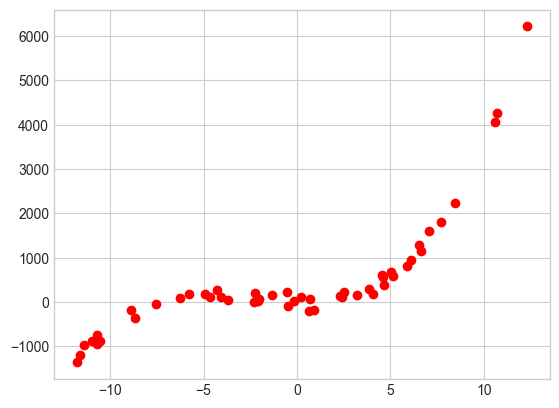

In [2]:
# FROM HW 1
plt.style.use('seaborn-whitegrid') 

noise_scale = 100 
number_of_samples = 50 

x =  25*(np.random.rand(number_of_samples, 1) - 0.5) 
y = 5 * x + 15 * x**2 + 2 * x**3 + noise_scale*np.random.randn(number_of_samples, 1) 

plt.plot(x,y,'ro')

In [3]:
class GeneticAlgorithm:
    
    def __init__(self, fitness, fitness_threshold, p, r, m, M, crossover_operator, take_min_fitness=True):
        
        self.fitness = fitness
        self.fitness_threshold = fitness_threshold
        
        self.crossover_operator = {
            
            'Simple Arithmetic Crossover': self.CrossoverOperator_simple_arithmetic_crossover,
            'Average': self.CrossoverOperator_average,
            'Single Arithmetic Crossover': self.CrossoverOperator_single_arithmetic_crossover,
            'Whole Arithmetic Crossover': self.CrossoverOperator_whole_arithmetic_crossover,
            
        }[crossover_operator]
        
        self.p = p
        self.r = r
        self.m = m

        self.f = f
        self.M = M
        
        self.scale = 50
        
        self.P = self.intialize_population()
        self.evaluations = self.evaluate()
        
        self.take_min_fitness = take_min_fitness
        self.best_fitness, self.best_h = self.determine_best_h()
        
        self.log = {
            'iteration #': [-1],
            'size of P': [self.P.shape[0]],
            'best fitness': [self.best_fitness],
            'best hypothesis': [self.best_h]
        }
    
    def CrossoverOperator(self):
        
        P = self.P
        r = self.r
        p = P.shape[0]
        
        num_parents = math.ceil(r*p)
        
        Pr_P = [self.Pr(h) for h in P]
        P_parent_indicies = np.random.choice(range(p), replace=False, size=num_parents, p=Pr_P)
        P_parents = P[P_parent_indicies]
        
        P_parents1 = P_parents[:int(num_parents/2)]
        P_parents2 = P_parents[int(num_parents/2):]
        couples = zip(P_parents1, P_parents2)
        
        return self.crossover_operator(couples)
    
    def CrossoverOperator_whole_arithmetic_crossover(self, couples):
        
        children = []
        
        for couple in couples:
            parent1, parent2 = couple
            alpha = np.random.randint(0, self.M-1)
            
            offspring1 = parent1 * alpha + parent2 * (1-alpha)
            offspring2 = parent2 * alpha + parent1 * (1-alpha)
            
            assert len(parent1) == len(parent2) == len(offspring1) == len(offspring2)

            children.append(offspring1)
            children.append(offspring2)
        
        return children
    
    def CrossoverOperator_single_arithmetic_crossover(self, couples):
        
        children = []
        
        for couple in couples:
            parent1, parent2 = couple
            alpha = np.random.randint(0, self.M-1)
            
            offspring1 = np.append(parent1[:alpha], [parent2[alpha]], parent1[alpha+1:])
            offspring2 = np.append(parent2[:alpha], [parent1[alpha]], parent2[alpha+1:])
            
            assert len(parent1) == len(parent2) == len(offspring1) == len(offspring2)

            children.append(offspring1)
            children.append(offspring2)
        
        return children
    
    
    def CrossoverOperator_simple_arithmetic_crossover(self, couples):
        
        children = []
        
        for couple in couples:
            parent1, parent2 = couple
            cutoff = np.random.randint(0, self.M-1)
            
            offspring1 = np.append(parent1[:cutoff], parent2[cutoff:])
            offspring2 = np.append(parent2[:cutoff], parent1[cutoff:])
            
            assert len(parent1) == len(parent2) == len(offspring1) == len(offspring2)

            children.append(offspring1)
            children.append(offspring2)
        
        return children
    
    def CrossoverOperator_average(self, couples):
        
        children = []
        
        for couple in couples:
            parent1, parent2 = couple
            weight = np.random.random()
            
            offspring1 = (
                np.array(parent1)*(weight) + np.array(parent2)* (1-weight)
            ) * 0.5
            offspring2 = (
                np.array(parent2)*(weight) + np.array(parent1)* (1-weight)
            ) * 0.5
            
            assert len(parent1) == len(parent2) == len(offspring1) == len(offspring2)
            
            children.append(offspring1)
            children.append(offspring2)

        return children
    
    def determine_best_h(self):
        
        evaluations = self.evaluate()
        
        if self.take_min_fitness:
            best_fitness, best_h = min(zip(evaluations, self.P), key=lambda x: x[0])
        else:
            best_fitness, best_h = max(zip(evaluations, self.P), key=lambda x: x[0])

        return best_fitness, best_h
    
    def evaluate(self):
        
        evaluations = np.array([
            self.fitness(h)
            for h in self.P
        ])
        
        return evaluations
            
    
    def intialize_population(self):
        
        P = self.scale * np.random.random(size=(self.p, self.M))
        return P
        
    def Pr(self, h):
        
        return self.fitness(h) / sum(self.fitness(h_j) for h_j in self.P)
    
    def select(self):
        
        P = self.P
        Pr_P = [self.Pr(h) for h in P]
        
        p = P.shape[0]
        r = self.r
        
        num_selected = math.ceil((1-r)*p)
        
        Ps_indicies = np.random.choice(range(p), replace=False, size=num_selected, p=Pr_P)
        Ps = P[Ps_indicies]
        
        return Ps
    
    def mutate(self, P):
        
        p = P.shape[0]
        num_mutations = math.ceil(self.m * p)
        
        mutant_indicies = np.random.choice(range(p), replace=False, size=num_mutations)
        
        for i in mutant_indicies:
            
            mutation_strength = self.scale * np.random.random() * (-1 ** np.random.randint(0, 1))
            mutation_index = np.random.randint(self.M)
            
            P[i][mutation_index] += mutation_strength
            
        return P
            
    
    def run(self):
        iterations = -1
        
        if self.take_min_fitness:
            continue_cond = lambda : self.best_fitness > self.fitness_threshold
        else:
            continue_cond = lambda : self.best_fitness < self.fitness_threshold

        while continue_cond() and iterations < 1000:
            
#             print(self.P.shape)
            
            # 1) Select
            Ps = self.select()
#             print(self.P.shape, Ps.shape)
            
            # 2) Crossover
            offspring = np.array(self.CrossoverOperator())            
            
#             print(self.P.shape, Ps.shape, offspring.shape)
                        
            # 3) Mutate
            offspring = self.mutate(offspring)
#             print(self.P.shape, Ps.shape, offspring.shape)
            
            # 4) Update
            Ps = np.array(Ps.tolist() + offspring.tolist())
            self.P = Ps
#             print(self.P.shape, Ps.shape, offspring.shape)
            
            # 5) Evaluate
            best_fitness, best_h = self.determine_best_h()
            
#             print('='*50)
            
            self.best_fitness = best_fitness
            self.best_h = best_h
            
            iterations += 1
            if iterations % 1 == 0:
                
                print(
                    "ITER. # %i:"
                    " Size of P: %s"
                    "| Best Fitness: %1.5e "
                    "| Best Hypothesis: %s" % (iterations, self.P.shape[0], self.best_fitness, self.best_h),
                    end = '\n'+'='*50 + '\n'
                )
                
                self.log['iteration #'].append(iterations)
                self.log['size of P'].append(self.P.shape[0])
                self.log['best fitness'].append(best_fitness)
                self.log['best hypothesis'].append(best_h)

        return best_h
    

In [4]:
fitness_threshold = 1

p = 500
r = 1
m = 0.01

x = x.reshape((-1))
M = 3

In [5]:
# crossover_operator = 'Simple Arithmetic Crossover'
# crossover_operator = 'Whole Arithmetic Crossover'
crossover_operator = 'Average'

In [6]:
def f(x, w):
    
    g = np.array([
        x**1, 
        x**2,  
        x**3
    ])
    
    return w @ g

def fitness(w):
    
    y_predicted = f(x, w)
    r = (y - y_predicted)**2

    return r.sum()
    

In [7]:
GA = GeneticAlgorithm(
    fitness=fitness, 
    fitness_threshold=fitness_threshold, 
    p=p, 
    r=r, 
    m=m, 
    M=M, 
    crossover_operator=crossover_operator, 
    take_min_fitness=True
)

In [8]:
GA.run()

ITER. # 0: Size of P: 500| Best Fitness: 6.31207e+09 | Best Hypothesis: [8.510692   4.36601626 1.15355119]
ITER. # 1: Size of P: 500| Best Fitness: 6.52451e+09 | Best Hypothesis: [2.36541495 2.17494846 1.2563003 ]
ITER. # 2: Size of P: 500| Best Fitness: 5.42055e+09 | Best Hypothesis: [3.93138215 1.29357872 0.50383196]
ITER. # 3: Size of P: 500| Best Fitness: 5.31534e+09 | Best Hypothesis: [ 2.04434514  0.84932562 -0.40714875]
ITER. # 4: Size of P: 500| Best Fitness: 5.21147e+09 | Best Hypothesis: [ 0.84107427  0.74396705 -0.12137012]
ITER. # 5: Size of P: 500| Best Fitness: 5.24892e+09 | Best Hypothesis: [0.42320264 0.38779699 0.1055287 ]
ITER. # 6: Size of P: 500| Best Fitness: 5.25664e+09 | Best Hypothesis: [ 0.1928352   0.17441827 -0.01645518]
ITER. # 7: Size of P: 500| Best Fitness: 5.26455e+09 | Best Hypothesis: [ 0.09648747  0.09586586 -0.00803704]
ITER. # 8: Size of P: 500| Best Fitness: 5.26832e+09 | Best Hypothesis: [ 0.05338633  0.05820919 -0.01634658]
ITER. # 9: Size of P: 

ITER. # 49: Size of P: 500| Best Fitness: 5.27403e+09 | Best Hypothesis: [-2.85024195e+00 -6.81776571e-04 -4.88448438e-04]
ITER. # 50: Size of P: 500| Best Fitness: 5.27398e+09 | Best Hypothesis: [-2.36457442e+00 -4.97446914e-04 -6.21314471e-04]
ITER. # 51: Size of P: 500| Best Fitness: 5.27403e+09 | Best Hypothesis: [-1.49263658e+00 -4.01861132e-04 -3.45212532e-05]
ITER. # 52: Size of P: 500| Best Fitness: 5.27394e+09 | Best Hypothesis: [-2.01269696e+00 -9.39342382e-05 -2.09867787e-04]
ITER. # 53: Size of P: 500| Best Fitness: 5.27401e+09 | Best Hypothesis: [-2.42858863e+00 -1.83636216e-04 -3.68175998e-03]
ITER. # 54: Size of P: 500| Best Fitness: 5.27396e+09 | Best Hypothesis: [-2.98505054e+00 -3.70549819e-05 -5.78286789e-05]
ITER. # 55: Size of P: 500| Best Fitness: 5.27399e+09 | Best Hypothesis: [-1.62577732e+00 -8.69863384e-05 -2.75087539e-03]
ITER. # 56: Size of P: 500| Best Fitness: 5.27406e+09 | Best Hypothesis: [-1.45524593e+00 -6.50558669e-04 -3.26375121e-05]
ITER. # 57: Size

ITER. # 97: Size of P: 500| Best Fitness: 5.27412e+09 | Best Hypothesis: [-2.70564211e+00 -1.80906931e-03 -1.18680204e-04]
ITER. # 98: Size of P: 500| Best Fitness: 5.27405e+09 | Best Hypothesis: [-2.07777936e+00 -1.15294411e-03 -6.02336069e-04]
ITER. # 99: Size of P: 500| Best Fitness: 5.27395e+09 | Best Hypothesis: [-2.72002507e+00 -6.32445989e-05 -5.59724624e-04]
ITER. # 100: Size of P: 500| Best Fitness: 5.27395e+09 | Best Hypothesis: [-2.30130862e+00 -8.84009069e-05 -1.70352902e-03]
ITER. # 101: Size of P: 500| Best Fitness: 5.27405e+09 | Best Hypothesis: [-1.29674980e+00 -2.82361346e-04 -1.71926663e-03]
ITER. # 102: Size of P: 500| Best Fitness: 5.27402e+09 | Best Hypothesis: [-1.82822412e+00 -6.91089748e-04 -1.15887767e-03]
ITER. # 103: Size of P: 500| Best Fitness: 5.27404e+09 | Best Hypothesis: [-1.55323228e+00 -5.20851161e-04 -1.79933751e-03]
ITER. # 104: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-1.72519996e+00 -1.31356708e-04 -2.90370823e-04]
ITER. # 105

ITER. # 144: Size of P: 500| Best Fitness: 5.27394e+09 | Best Hypothesis: [-2.65770222e+00 -1.01443048e-04 -9.50899371e-05]
ITER. # 145: Size of P: 500| Best Fitness: 5.27402e+09 | Best Hypothesis: [-1.35436346e+00 -9.55835967e-05 -2.36714732e-05]
ITER. # 146: Size of P: 500| Best Fitness: 5.27399e+09 | Best Hypothesis: [-1.82954454e+00 -4.13463662e-04 -5.15353880e-04]
ITER. # 147: Size of P: 500| Best Fitness: 5.27399e+09 | Best Hypothesis: [-1.80429278e+00 -3.64753289e-04 -3.31087036e-04]
ITER. # 148: Size of P: 500| Best Fitness: 5.27396e+09 | Best Hypothesis: [-2.32815541e+00 -3.88681856e-04 -1.96551355e-04]
ITER. # 149: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-2.31523866e+00 -3.60542868e-04 -7.43807080e-04]
ITER. # 150: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-2.05005672e+00 -3.49603198e-04 -3.25954529e-04]
ITER. # 151: Size of P: 500| Best Fitness: 5.27396e+09 | Best Hypothesis: [-2.28846007e+00 -3.28199517e-04 -3.50218840e-04]
ITER. # 

ITER. # 192: Size of P: 500| Best Fitness: 5.27395e+09 | Best Hypothesis: [-2.65965297e+00 -8.66132786e-05 -3.42287259e-04]
ITER. # 193: Size of P: 500| Best Fitness: 5.27393e+09 | Best Hypothesis: [-2.43484831e+00 -1.07887303e-04 -1.83178666e-04]
ITER. # 194: Size of P: 500| Best Fitness: 5.27394e+09 | Best Hypothesis: [-2.26871134e+00 -2.06739188e-04 -1.15201811e-04]
ITER. # 195: Size of P: 500| Best Fitness: 5.27395e+09 | Best Hypothesis: [-2.39981285e+00 -2.05798343e-04 -5.99212904e-04]
ITER. # 196: Size of P: 500| Best Fitness: 5.27396e+09 | Best Hypothesis: [-2.22123783e+00 -2.81956759e-04 -5.71335354e-04]
ITER. # 197: Size of P: 500| Best Fitness: 5.27398e+09 | Best Hypothesis: [-1.87794020e+00 -3.50297992e-04 -9.84469952e-04]
ITER. # 198: Size of P: 500| Best Fitness: 5.27393e+09 | Best Hypothesis: [-2.48931303e+00 -3.85358772e-05 -1.58631163e-04]
ITER. # 199: Size of P: 500| Best Fitness: 5.27395e+09 | Best Hypothesis: [-1.94982329e+00 -6.95677641e-05 -6.07072808e-04]
ITER. # 

ITER. # 239: Size of P: 500| Best Fitness: 5.27401e+09 | Best Hypothesis: [-1.76402094e+00 -6.02462213e-04 -1.78217688e-04]
ITER. # 240: Size of P: 500| Best Fitness: 5.27400e+09 | Best Hypothesis: [-1.54127792e+00 -1.50459887e-04 -1.18340561e-04]
ITER. # 241: Size of P: 500| Best Fitness: 5.27401e+09 | Best Hypothesis: [-1.92196002e+00 -6.87041678e-04 -3.44277702e-05]
ITER. # 242: Size of P: 500| Best Fitness: 5.27424e+09 | Best Hypothesis: [-1.79790802e+00 -2.79086425e-03 -8.93392965e-04]
ITER. # 243: Size of P: 500| Best Fitness: 5.27394e+09 | Best Hypothesis: [-2.43034151e+00 -1.99051000e-04 -1.11946008e-04]
ITER. # 244: Size of P: 500| Best Fitness: 5.27399e+09 | Best Hypothesis: [-1.59742437e+00 -1.36967428e-04 -1.81275231e-04]
ITER. # 245: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-2.02509980e+00 -2.33203488e-04 -1.79053110e-03]
ITER. # 246: Size of P: 500| Best Fitness: 5.27410e+09 | Best Hypothesis: [-1.27027308e+00 -7.58616856e-04 -4.80507076e-04]
ITER. # 

ITER. # 286: Size of P: 500| Best Fitness: 5.27400e+09 | Best Hypothesis: [-1.90849566e+00 -6.41074385e-04 -1.20956461e-04]
ITER. # 287: Size of P: 500| Best Fitness: 5.27415e+09 | Best Hypothesis: [-7.39188452e-01 -1.08573404e-04 -1.69193514e-03]
ITER. # 288: Size of P: 500| Best Fitness: 5.27426e+09 | Best Hypothesis: [-2.03469866e-03 -5.57404222e-05 -1.42345098e-02]
ITER. # 289: Size of P: 500| Best Fitness: 5.27410e+09 | Best Hypothesis: [-2.86596057e+00 -1.48033087e-03 -3.75808002e-05]
ITER. # 290: Size of P: 500| Best Fitness: 5.27396e+09 | Best Hypothesis: [-2.79524120e+00 -8.90285922e-05 -4.18697065e-04]
ITER. # 291: Size of P: 500| Best Fitness: 5.27413e+09 | Best Hypothesis: [-8.52078185e-01 -2.81289082e-05 -1.50631010e-04]
ITER. # 292: Size of P: 500| Best Fitness: 5.27394e+09 | Best Hypothesis: [-2.27524843e+00 -1.96045680e-04 -7.79402221e-05]
ITER. # 293: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-1.73803390e+00 -1.88239354e-04 -2.25958777e-04]
ITER. # 

ITER. # 333: Size of P: 500| Best Fitness: 5.27426e+09 | Best Hypothesis: [-3.77570634e-05 -1.28444935e-04 -1.32762550e-02]
ITER. # 334: Size of P: 500| Best Fitness: 5.27426e+09 | Best Hypothesis: [-2.38501674e-03 -1.95626781e-05 -1.70527779e-02]
ITER. # 335: Size of P: 500| Best Fitness: 5.27399e+09 | Best Hypothesis: [-2.97102875e+00 -3.01853286e-04 -2.20449917e-04]
ITER. # 336: Size of P: 500| Best Fitness: 5.27412e+09 | Best Hypothesis: [-9.24118005e-01 -1.13138933e-04 -2.74524312e-04]
ITER. # 337: Size of P: 500| Best Fitness: 5.27422e+09 | Best Hypothesis: [-1.77208856e+00 -2.64773081e-03 -6.37309737e-04]
ITER. # 338: Size of P: 500| Best Fitness: 5.27426e+09 | Best Hypothesis: [-2.68541899e-04 -9.61887561e-05 -1.70263925e-02]
ITER. # 339: Size of P: 500| Best Fitness: 5.27399e+09 | Best Hypothesis: [-2.51695017e+00 -3.04591345e-04 -1.99923667e-03]
ITER. # 340: Size of P: 500| Best Fitness: 5.27393e+09 | Best Hypothesis: [-2.63102400e+00 -4.90572503e-05 -9.31556475e-05]
ITER. # 

ITER. # 380: Size of P: 500| Best Fitness: 5.27396e+09 | Best Hypothesis: [-2.73704790e+00 -1.94060120e-04 -4.46849885e-05]
ITER. # 381: Size of P: 500| Best Fitness: 5.27396e+09 | Best Hypothesis: [-1.96589834e+00 -2.89306943e-04 -6.76560103e-05]
ITER. # 382: Size of P: 500| Best Fitness: 5.27409e+09 | Best Hypothesis: [-2.29206654e+00 -1.65787334e-03 -6.97616844e-05]
ITER. # 383: Size of P: 500| Best Fitness: 5.27427e+09 | Best Hypothesis: [-5.99068485e-04 -3.72103019e-05 -1.84778679e-02]
ITER. # 384: Size of P: 500| Best Fitness: 5.27423e+09 | Best Hypothesis: [-0.43168759 -0.00051111 -0.01380261]
ITER. # 385: Size of P: 500| Best Fitness: 5.27415e+09 | Best Hypothesis: [-1.20426871e+00 -1.08973394e-03 -1.60837590e-03]
ITER. # 386: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-2.42498904e+00 -4.67124051e-04 -2.88526490e-04]
ITER. # 387: Size of P: 500| Best Fitness: 5.27409e+09 | Best Hypothesis: [-1.10619796e+00 -2.23121510e-04 -1.42471780e-04]
ITER. # 388: Size of

ITER. # 428: Size of P: 500| Best Fitness: 5.27426e+09 | Best Hypothesis: [-3.12575320e-03 -8.02130236e-05 -1.34920740e-02]
ITER. # 429: Size of P: 500| Best Fitness: 5.27402e+09 | Best Hypothesis: [-1.93928397e+00 -8.40372641e-04 -5.02849405e-04]
ITER. # 430: Size of P: 500| Best Fitness: 5.27398e+09 | Best Hypothesis: [-2.49611275e+00 -4.16405261e-04 -6.48611393e-04]
ITER. # 431: Size of P: 500| Best Fitness: 5.27408e+09 | Best Hypothesis: [-2.02243692e+00 -1.43177832e-03 -1.20141801e-04]
ITER. # 432: Size of P: 500| Best Fitness: 5.27418e+09 | Best Hypothesis: [-8.90200890e-01 -6.54500860e-04 -1.28781388e-04]
ITER. # 433: Size of P: 500| Best Fitness: 5.27401e+09 | Best Hypothesis: [-1.57067058e+00 -3.50818606e-04 -1.25169949e-04]
ITER. # 434: Size of P: 500| Best Fitness: 5.27395e+09 | Best Hypothesis: [-2.66118195e+00 -1.84041370e-04 -3.22842626e-04]
ITER. # 435: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-1.75708286e+00 -1.23628654e-04 -2.55071973e-04]
ITER. # 

ITER. # 476: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-1.84580960e+00 -2.65207234e-04 -1.16615526e-04]
ITER. # 477: Size of P: 500| Best Fitness: 5.27398e+09 | Best Hypothesis: [-1.57962763e+00 -7.53376555e-05 -3.20349506e-05]
ITER. # 478: Size of P: 500| Best Fitness: 5.27398e+09 | Best Hypothesis: [-1.75624291e+00 -2.68485332e-04 -3.84119887e-05]
ITER. # 479: Size of P: 500| Best Fitness: 5.27415e+09 | Best Hypothesis: [-7.35208610e-01 -2.85888817e-04 -4.36306249e-03]
ITER. # 480: Size of P: 500| Best Fitness: 5.27398e+09 | Best Hypothesis: [-2.03949996e+00 -2.36141693e-04 -2.61857877e-03]
ITER. # 481: Size of P: 500| Best Fitness: 5.27404e+09 | Best Hypothesis: [-3.41108943e+00 -6.28270415e-05 -1.11572230e-04]
ITER. # 482: Size of P: 500| Best Fitness: 5.27411e+09 | Best Hypothesis: [-1.04187345e+00 -2.75507986e-04 -6.18653872e-05]
ITER. # 483: Size of P: 500| Best Fitness: 5.27393e+09 | Best Hypothesis: [-2.41322176e+00 -5.81840993e-05 -1.07816972e-04]
ITER. # 

ITER. # 523: Size of P: 500| Best Fitness: 5.27404e+09 | Best Hypothesis: [-3.28208620e+00 -2.61431754e-04 -1.94755129e-04]
ITER. # 524: Size of P: 500| Best Fitness: 5.27411e+09 | Best Hypothesis: [-9.52244841e-01 -1.50206474e-04 -1.36166525e-03]
ITER. # 525: Size of P: 500| Best Fitness: 5.27420e+09 | Best Hypothesis: [-2.90048258e+00 -1.29995238e-03 -4.42343682e-03]
ITER. # 526: Size of P: 500| Best Fitness: 5.27416e+09 | Best Hypothesis: [-8.59107212e-01 -4.93760493e-04 -1.33934884e-03]
ITER. # 527: Size of P: 500| Best Fitness: 5.27401e+09 | Best Hypothesis: [-1.73236188e+00 -3.61945610e-04 -2.99188021e-03]
ITER. # 528: Size of P: 500| Best Fitness: 5.27421e+09 | Best Hypothesis: [-5.87725539e-01 -1.69909051e-04 -1.18097932e-03]
ITER. # 529: Size of P: 500| Best Fitness: 5.27398e+09 | Best Hypothesis: [-2.17742633e+00 -5.83634959e-04 -2.36679115e-04]
ITER. # 530: Size of P: 500| Best Fitness: 5.27406e+09 | Best Hypothesis: [-1.92974840e+00 -1.17509969e-03 -2.13573136e-04]
ITER. # 

ITER. # 570: Size of P: 500| Best Fitness: 5.27406e+09 | Best Hypothesis: [-1.22962306e+00 -2.76539218e-04 -1.06332087e-03]
ITER. # 571: Size of P: 500| Best Fitness: 5.27401e+09 | Best Hypothesis: [-2.29674172e+00 -7.50078936e-04 -9.86687642e-04]
ITER. # 572: Size of P: 500| Best Fitness: 5.27402e+09 | Best Hypothesis: [-1.96944530e+00 -7.51808296e-04 -1.12851521e-03]
ITER. # 573: Size of P: 500| Best Fitness: 5.27418e+09 | Best Hypothesis: [-6.80056589e-01 -1.05906687e-04 -3.99302747e-04]
ITER. # 574: Size of P: 500| Best Fitness: 5.27395e+09 | Best Hypothesis: [-1.90626696e+00 -1.04398831e-04 -1.17513760e-04]
ITER. # 575: Size of P: 500| Best Fitness: 5.27417e+09 | Best Hypothesis: [-3.66373153e+00 -6.27753261e-04 -4.08020478e-04]
ITER. # 576: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-2.02244799e+00 -4.03708507e-04 -2.08650460e-04]
ITER. # 577: Size of P: 500| Best Fitness: 5.27415e+09 | Best Hypothesis: [-8.51763727e-01 -2.51270241e-04 -2.49311875e-04]
ITER. # 

ITER. # 617: Size of P: 500| Best Fitness: 5.27393e+09 | Best Hypothesis: [-2.04410893e+00 -2.25661447e-05 -4.67390941e-04]
ITER. # 618: Size of P: 500| Best Fitness: 5.27398e+09 | Best Hypothesis: [-1.62994492e+00 -7.69858467e-05 -5.30640537e-05]
ITER. # 619: Size of P: 500| Best Fitness: 5.27395e+09 | Best Hypothesis: [-1.81730757e+00 -6.80531579e-05 -5.91867316e-05]
ITER. # 620: Size of P: 500| Best Fitness: 5.27412e+09 | Best Hypothesis: [-8.93342017e-01 -3.35086152e-05 -3.62985743e-05]
ITER. # 621: Size of P: 500| Best Fitness: 5.27425e+09 | Best Hypothesis: [-1.14718890e-03 -1.73218116e-05 -1.50365865e-02]
ITER. # 622: Size of P: 500| Best Fitness: 5.27397e+09 | Best Hypothesis: [-2.22564226e+00 -2.26761827e-04 -1.74352772e-03]
ITER. # 623: Size of P: 500| Best Fitness: 5.27396e+09 | Best Hypothesis: [-1.76451285e+00 -1.16775444e-04 -1.23359114e-04]
ITER. # 624: Size of P: 500| Best Fitness: 5.27393e+09 | Best Hypothesis: [-2.28135034e+00 -2.53351267e-05 -4.34597637e-04]
ITER. # 

KeyboardInterrupt: 